In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# 1. Data Preprocessing

In [3]:
lob_data= pd.read_csv("C:\\Users\\yhb\\dsmp-2024-group23\\Ryan\\datasets\\resampled_lob_minALL.csv")
lob_data['Datetime'] = pd.to_datetime(lob_data['Datetime'])

lob_data['price']=(lob_data['Max Bid Price']*lob_data['Max Bid Quantity']+lob_data['Min Ask Price']*lob_data['Min Ask Quantity'])/(lob_data['Max Bid Quantity']+lob_data['Min Ask Quantity'])
# lob_data

In [4]:
# ofi
def calculate_ofi(df):
    df['delta_bid'] = df['Max Bid Price'].diff().fillna(0)
    df['delta_ask'] = df['Min Ask Price'].diff().fillna(0)
    
        # 计算 ΔW^m(t_n)
    df['delta_w'] = df.apply(
        lambda row: row['Max Bid Quantity'] if row['delta_bid'] > 0 else
                   (-row['Max Bid Quantity'] if row['delta_bid'] < 0 else
                    row['Max Bid Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Max Bid Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    # 计算 ΔV^m(t_n)
    df['delta_v'] = df.apply(
        lambda row: -row['Min Ask Quantity'] if row['delta_ask'] > 0 else
                   (row['Min Ask Quantity'] if row['delta_ask'] < 0 else
                    row['Min Ask Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Min Ask Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    # 计算 OFI
    df['ofi'] = df['delta_w'] + df['delta_v']
    
    return df['ofi']

calculate_ofi(lob_data)
lob_data=lob_data[['Datetime','Min Ask Price','Max Bid Price','price','Total Bid Quantity','Total Ask Quantity','Min Ask Quantity','Max Bid Quantity','ofi']]
# drop the first row (ofi is 0)
lob_data = lob_data.iloc[1:]

In [5]:
def calculate_rsi(data, window):
    """
    计算给定数据的相对强弱指数（RSI）。
    
    :param data: 包含价格数据的Pandas Series。
    :param window: 用于计算RSI的窗口大小，默认为14。
    :return: 包含RSI值的Pandas Series。
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

lob_data['RSI'] = calculate_rsi(lob_data['price'], window=5) # calculate RSI
lob_data['MA'] = lob_data['price'].rolling(window=5).mean() # Cclculate moving avg
lob_data['Momentum'] = lob_data['price'] - lob_data['price'].shift(5) # Calculate momentum
# lob_data.head()

In [6]:
# This is only for trading volume, not for modeling
# # 设置一个时间窗口
rolling_window = 5  # 例如，我们使用过去5个时间点的数据来计算波动率

# 计算对数收益率 shift(1)是为了计算相对于前一分钟的收益率
lob_data['Log Return Max Bid'] = np.log(lob_data['Max Bid Price'] / lob_data['Max Bid Price'].shift(1))
lob_data['Log Return Min Ask'] = np.log(lob_data['Min Ask Price'] / lob_data['Min Ask Price'].shift(1))

# 计算滚动标准差作为波动率的度量
lob_data['Volatility Max Bid'] = lob_data['Log Return Max Bid'].rolling(window=rolling_window).std()
lob_data['Volatility Min Ask'] = lob_data['Log Return Min Ask'].rolling(window=rolling_window).std()

# 由于滚动计算会产生缺失值，我们通常会删除这些值
# lob_data.dropna(inplace=True)

# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_fator=10):
    """
    根据波动率和最大可交易量调整交易量。
    volatility: 当前波动率
    max_tradeable_quantity: 该时间点的最大可交易量（对于买入操作，是Min Ask Quantity；对于卖出操作，是Max Bid Quantity）
    base_quantity: 基础交易量
    risk_tolerance: 风险容忍度，取值范围为[0, 1]，数值越小表风险承受越大，交易量越大
    """
    # 基于波动率调整的交易量
    adjusted_quantity = base_quantity / (volatility*risk_tolerance*scaler_fator)
    adjusted_quantity = max(1, round(adjusted_quantity))  # 确保至少交易1单位，并且是整数

    # 确保交易量不超过最大可交易量 make sure the trade quantity is no more than the max tradeable quantity
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

In [27]:
# split data
lob_data.columns

Index(['Datetime', 'Min Ask Price', 'Max Bid Price', 'price',
       'Total Bid Quantity', 'Total Ask Quantity', 'Min Ask Quantity',
       'Max Bid Quantity', 'ofi', 'RSI', 'MA20', 'Momentum20',
       'Log Return Max Bid', 'Log Return Min Ask', 'Volatility Max Bid',
       'Volatility Min Ask'],
      dtype='object')

In [7]:
# drop na
lob_data.dropna(inplace=True)

# split data
split_index = int(0.8 * len(lob_data))
features = ['Total Bid Quantity', 'Total Ask Quantity', 'Min Ask Quantity', 'Max Bid Quantity', 'ofi', 'RSI', 'MA', 'Momentum']
target = 'price'
X_train, X_test = lob_data[features][:split_index], lob_data[features][split_index:]
y_train, y_test = lob_data[target][:split_index], lob_data[target][split_index:]

In [65]:
lob_data

,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,RSI,MA,Momentum
6,2025-01-02 00:06:00,266.854972,256.726519,261.067285,34108.0,15650.0,3,4,-7,55.339868,263.742476,1.021921
7,2025-01-02 00:07:00,265.266362,260.334855,262.184170,22859.0,13753.0,3,5,8,27.992479,263.220043,-2.612162
8,2025-01-02 00:08:00,267.154976,260.825449,263.990212,19946.0,10646.0,3,3,0,40.620967,262.950044,-1.349994
9,2025-01-02 00:09:00,267.283837,262.383706,264.343758,32991.0,12274.0,2,3,1,43.397535,262.750652,-0.996960
10,2025-01-02 00:10:00,270.135854,265.058824,266.751167,39298.0,17144.0,2,4,2,83.778297,263.667319,4.583332
...,...,...,...,...,...,...,...,...,...,...,...,...
62853,2025-07-01 08:13:00,151.230132,96.942053,120.208373,18271.0,10399.0,3,4,-1,20.616474,123.302040,-11.389644
62854,2025-07-01 08:14:00,200.771852,107.148148,144.597630,16849.0,10211.0,2,3,1,72.426903,126.817785,17.578723
62855,2025-07-01 08:15:00,174.894172,107.539877,129.991309,29053.0,9511.0,2,4,6,56.959034,128.204969,6.935923
62856,2025-07-01 08:16:00,174.897866,108.716463,125.261814,33890.0,9471.0,2,6,4,53.939160,129.034146,4.145886


# 1. ARIMA

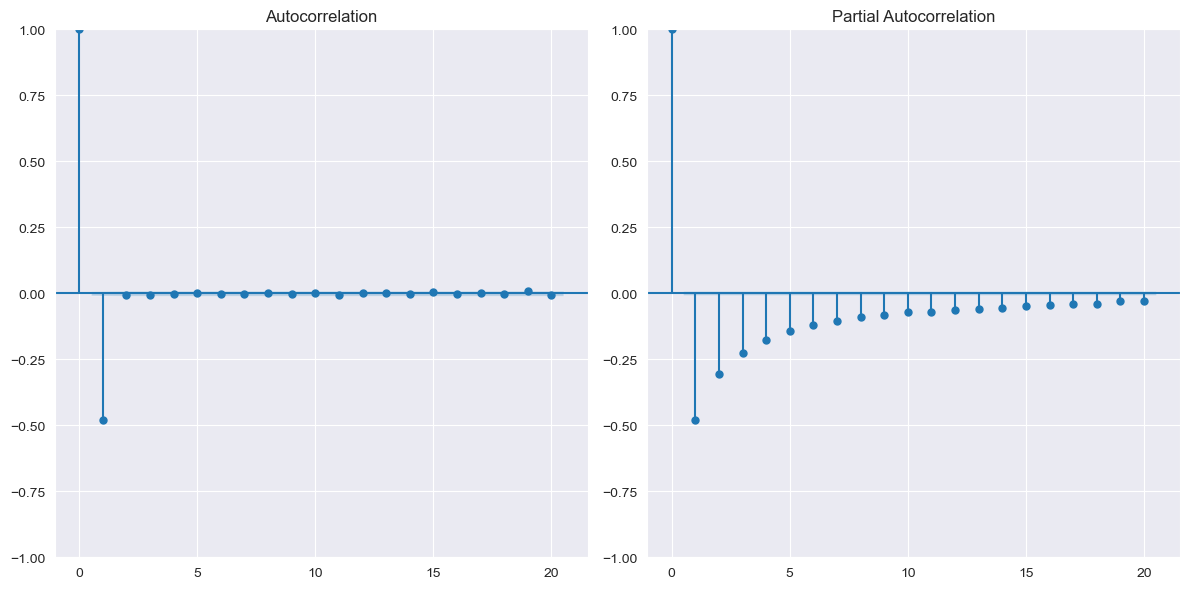

(-50.132170619836785,
 0.0,
 46,
 62810,
 {'1%': -3.4304541166577067,
  '5%': -2.8615860176312657,
  '10%': -2.5667944936271643},
 444053.6898218971)

In [19]:
# 对Min Ask Price进行一阶差分
lob_data['Price Diff'] = lob_data['price'].diff()

# 再次对一阶差分后的数据进行ADF平稳性检测
adf_result_diff = adfuller(lob_data['Price Diff'].dropna())

# 再次绘制ACF和PACF图，这次是对一阶差分后的数据
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(lob_data['Price Diff'].dropna(), ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(lob_data['Price Diff'].dropna(), ax=plt.gca(), lags=20)
plt.tight_layout()
plt.show()

adf_result_diff




**自相关和偏自相关图分析**:
- 自相关图（ACF）显示在第一个滞后处有一个显著的跳跃，之后迅速接近零并保持在置信区间内。这通常表示数据经过差分后已经变得平稳。
- 偏自相关图（PACF）显示在第一个滞后之后的所有滞后点都接近零并且均在置信区间内，这也是一个平稳时间序列的标志。

**ADF检验结果分析**:
- ADF检验的统计值为-50.13，远远小于三个置信水平（1%，5%，10%）对应的临界值（-3.43, -2.86, -2.57）。这说明该时间序列是平稳的，不存在单位根。
- p值为0.0，表明我们可以在任何常见的置信水平下拒绝原假设（存在单位根），从而确认时间序列的平稳性。
- 该检验的滞后数为46，考虑到数据点的总数为62810，这个滞后数相对是比较小的。
- ADF检验的临界值表明，该序列在不同的置信水平下都表现出显著的平稳性。

综合来看，时间序列经过一阶差分后已经达到了平稳，可以进行进一步的时间序列分析或建模，比如ARIMA模型的建立。平稳性是进行这些分析的前提条件，因为非平稳的时间序列可能导致模型预测的不准确。

In [4]:
# split data
train_size = int(0.9 * len(lob_data))
train_set = lob_data['price'][:train_size]
test_set = lob_data['price'][train_size:]

# 对Min Ask Price进行ARIMA模型拟合
model = ARIMA(train_set, order=(2, 1, 2))
model_fit = model.fit()
    
# 输出模型的统计信息
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                56572
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -199666.966
Date:                Fri, 19 Apr 2024   AIC                         399343.931
Time:                        12:48:29   BIC                         399388.648
Sample:                             0   HQIC                        399357.858
                              - 56572                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6682      0.060     11.104      0.000       0.550       0.786
ar.L2         -0.0083      0.008     -1.016      0.310      -0.024       0.008
ma.L1         -1.5018      0.060    -25.012      0.0

E:\Programming\anaconda3\envs\mytorch\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


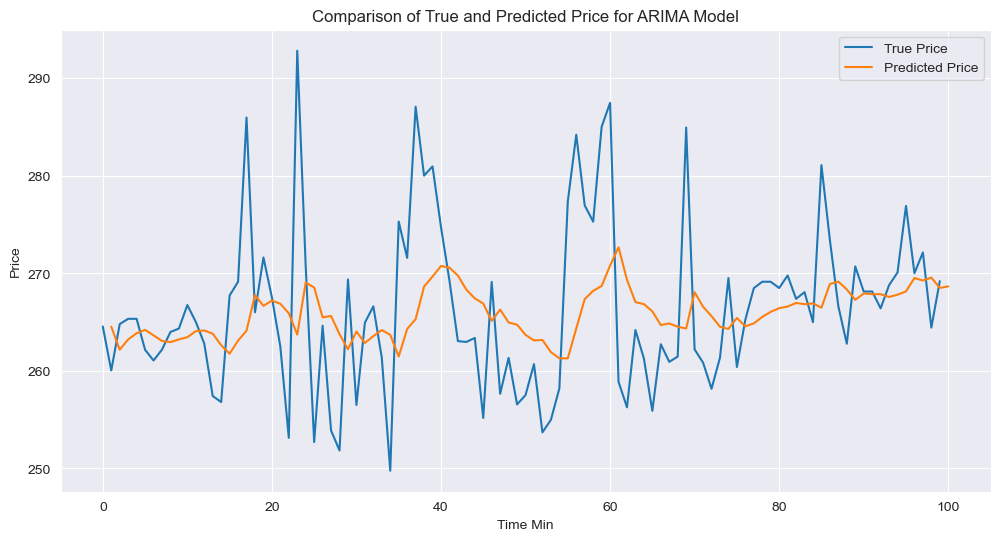

In [5]:
# 预测
predictions = model_fit.predict(start=1, end=len(lob_data)-1, typ='levels')

# 绘制预测值和真实值
plt.figure(figsize=(12, 6))
plt.plot(lob_data['price'][:100], label='True Price')
plt.plot(predictions[:100], label='Predicted Price')
plt.title('Comparison of True and Predicted Price for ARIMA Model')
plt.xlabel('Time Min')
plt.ylabel('Price')
plt.legend()
plt.show()

In [96]:
# exog means exogenous variables
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(2, 1, 0), seasonal_order=(1, 1, 1, 60))  # 季节性参数也需要根据数据调整
results = model.fit()

# 检查模型摘要
print(results.summary())

# 进行预测
pred = results.get_forecast(steps=len(y_test), exog=X_test) # 预测对象
y_pred_sma = pred.predicted_mean # 预测均值

# 可以比较预测结果和实际数据
mse = mean_squared_error(y_test, y_pred_sma)
print("MSE:", mse)

E:\Programming\anaconda3\envs\mytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Programming\anaconda3\envs\mytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MemoryError: Unable to allocate 5.67 GiB for an array with shape (123, 123, 50282) and data type float64

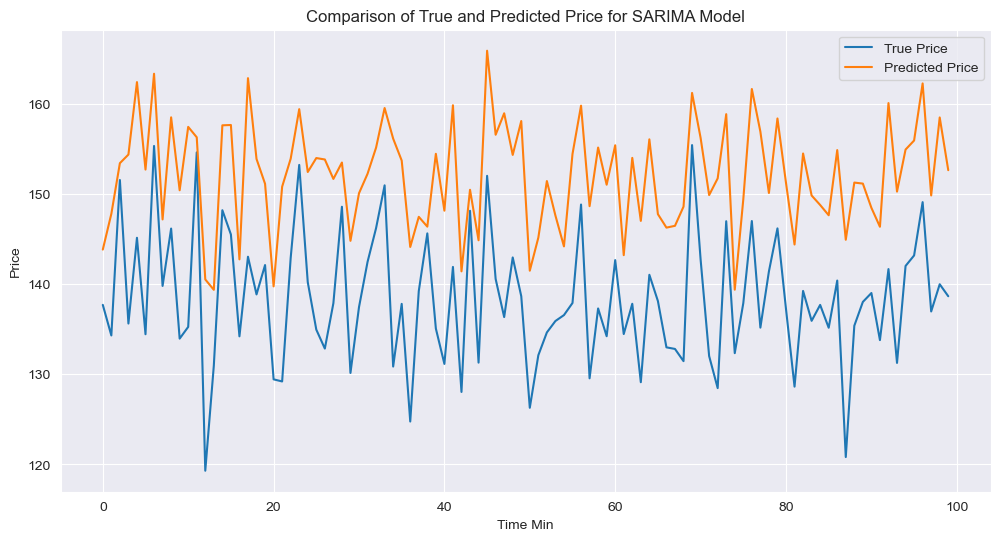

In [94]:
y_test_values=y_test.values
y_pred_values=y_pred_sma.values

plt.figure(figsize=(12, 6))
plt.plot(y_test_values[1000:1100], label='True Price')
plt.plot(y_pred_values[1000:1100], label='Predicted Price')
plt.title('Comparison of True and Predicted Price for SARIMA Model')
plt.xlabel('Time Min')
plt.ylabel('Price')
plt.legend()
plt.show()

SARIMA 模型在进行长期预测时可能会逐渐失去精确度，特别是如果模型过度依赖于靠近训练集末尾的数据。随着预测步数的增加，初始条件的影响可能会减弱，导致预测偏差增大。


# 2. XGBoost Model
使用arima模型预测price发现效果并不是很好，因为arima基于线性模型，而price的变化是非线性的，因此我们需要使用更加复杂的模型来预测price。

Sklearn提供了TimeseriesSplit函数，可以用于时间序列数据的交叉验证。我们可以使用这个函数来划分训练集和测试集，然后使用XGBoost模型进行预测。

In [8]:
# 使用XGBoost模型进行预测
# # 标准化特征,只对非时间特征进行标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
# 使用TimeSeriesSplit进行交叉验证，并使用grid search寻找最佳参数
tscv = TimeSeriesSplit(n_splits=5)

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# 使用GridSearchCV进行交叉验证
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# 输出最佳参数
grid_search.best_params_ # {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

In [9]:
# 使用最佳参数训练模型
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42,n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)

# 预测测试集
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 计算测试集的MSE
mse = np.mean((y_pred_xgb - y_test) ** 2)
# 计算R^2
r2 = xgb_model.score(X_test, y_test)
mse, r2

(158.11646916757448, -714.548125567051)

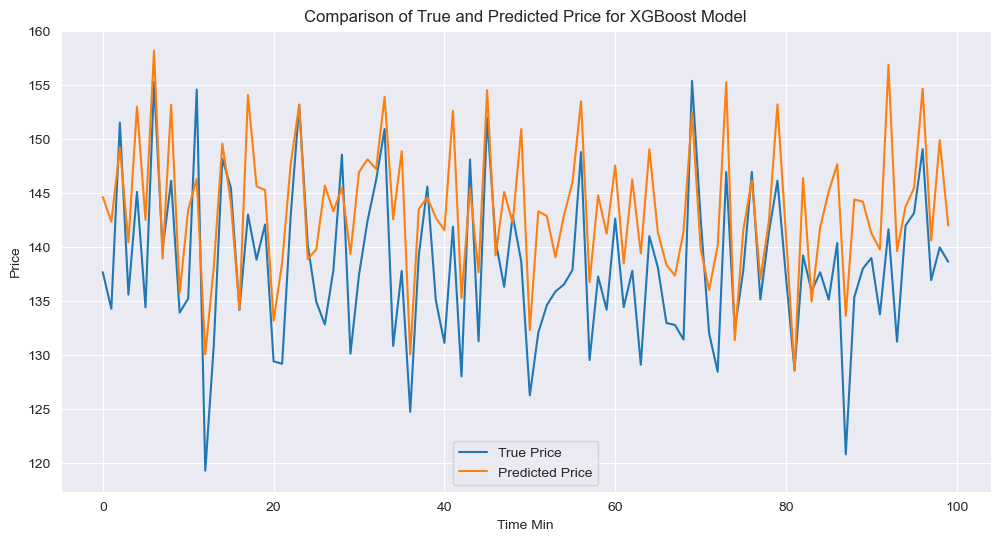

In [12]:
y_test_value=y_test.values
# 对比预测值和真实值,
plt.figure(figsize=(12, 6))
plt.plot(y_test_value[1000:1100], label='True Price')
plt.plot(y_pred_xgb[1000:1100] ,label='Predicted Price')
plt.title('Comparison of True and Predicted Price for XGBoost Model')
plt.xlabel('Time Min')
plt.ylabel('Price')
plt.legend()
plt.show()

# 3. Random Forest 

In [13]:
# 随机森林模型预测
from sklearn.ensemble import RandomForestRegressor

# 训练随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)
rf_model.fit(X_train, y_train)

# 预测测试集
y_pred_rf = rf_model.predict(X_test)

# 计算测试集的MSE
mse = np.mean((y_pred_rf - y_test) ** 2)
# 计算R^2
r2 = rf_model.score(X_test, y_test)
mse, r2


(201.57319564901476, -1.3190061009756104)

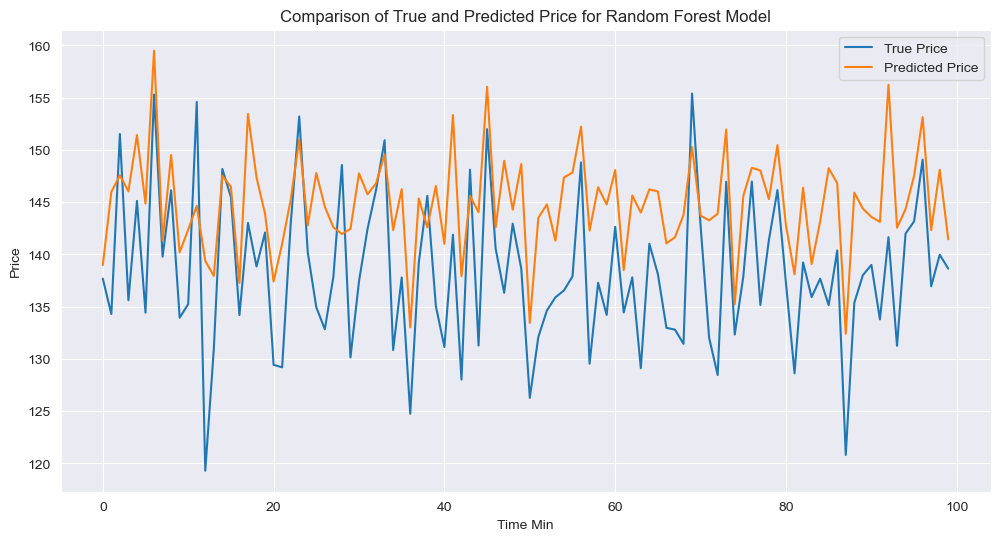

In [14]:
y_test_value=y_test.values
# 对比预测值和真实值,
plt.figure(figsize=(12, 6))
plt.plot(y_test_value[1000:1100], label='True Price')
plt.plot(y_pred_rf[1000:1100], label='Predicted Price')
plt.title('Comparison of True and Predicted Price for Random Forest Model')
plt.xlabel('Time Min')
plt.ylabel('Price')
plt.legend()
plt.show()


# 4. Trading Strategy

In [30]:
initial_capital = 100000
capital = initial_capital
has_position = False
trade_log = []
# capital_history = [initial_capital]
current_holdings = 0
transaction_cost = 0
# trade_quantity = 1


for i in range(len(X_test)-1):

    predict_price = y_pred_xgb[i+1]
    current_price = y_pred_xgb[i]
    # predict_price = y_pred_rf[i + 1]
    # current_price = y_pred_rf[i]
    
    # adjust the trade quantity based on the volatility. make the trade quantity no more than the max tradeable quantity
    current_volatility_buy = lob_data['Volatility Min Ask'].iloc[i + split_index]
    current_volatility_sell = lob_data['Volatility Max Bid'].iloc[i + split_index]
    ofi = lob_data['ofi'].iloc[i + split_index]
    rsi = lob_data['RSI'].iloc[i + split_index]

    # buy policy: if the model predicts the ask price will go up, and the current has no position, then buy
    if not has_position and predict_price > current_price:
        # if not has_position and rsi>60:

        # buy_price=X_test['price'].iloc[i]
        buy_price = lob_data['price'].iloc[i + split_index]
        buy_quantity = adjust_trade_quantity(current_volatility_buy, lob_data['Min Ask Quantity'].iloc[i + split_index],
                                             scaler_fator=10)
        capital -= buy_price * buy_quantity * (1 + transaction_cost)
        current_holdings += buy_quantity
        has_position = True
        trade_log.append({'action': 'BUY', 'Time': lob_data['Datetime'].iloc[i + split_index], 'price': buy_price,
                          'capital': capital, 'quantity': buy_quantity,
                          'max quantity': lob_data['Min Ask Quantity'].iloc[i + split_index]})

    # sell policy: if the model predicts the bid price will go down, and the current has position, then sell
    elif has_position and predict_price < current_price:
        # elif has_position and rsi<40:

        # sell_price=X_test['price'].iloc[i]
        sell_price = lob_data['price'].iloc[i + split_index]
        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell,
                                                                    lob_data['Max Bid Quantity'].iloc[i + split_index],
                                                                    scaler_fator=20))
        capital += sell_price * sell_quantity * (1 - transaction_cost)
        current_holdings -= sell_quantity
        has_position = False
        trade_log.append({'action': 'SELL', 'Time': lob_data['Datetime'].iloc[i + split_index], 'price': sell_price,
                          'capital': capital, 'quantity': sell_quantity,
                          'max quantity': lob_data['Max Bid Quantity'].iloc[i + split_index]})

    # hold policy: if the model predicts the price will not change, and the current has position, then hold
    # elif has_position and -2 <= ofi <= 2:
    #     trade_log.append({'action': 'HOLD', 'Time': lob_data['Datetime'].iloc[i + split_index],
    #                       'price': lob_data['price'].iloc[i + split_index], 'capital': capital,
    #                       'quantity': current_holdings,
    #                       'max quantity': lob_data['Max Bid Quantity'].iloc[i + split_index], 'prediction': prediction})

# 计算最终资本
final_capital = capital
profit = final_capital - initial_capital
# 只计算buy和sell的次数
number_of_trades = len([trade for trade in trade_log if trade['action'] in ['BUY', 'SELL']])
# number_of_trades = len(trade_log)

# 保留两位小数
# print('Final capital: ', round(final_capital))
print('Profit: ', round(profit))
# print('Final return: ', round(profit / initial_capital * 100, 2), '%')
print('Number of trades: ', number_of_trades)

Profit:  68362
Number of trades:  8721


### Strategy 1
buy policy: if has no position, and the ofi is greater than 2, then buy
sell policy: if has position, and the ofi is less than -2, then sell
hold policy: if has position, and the ofi is between -2 and 2, then hold

Profit:  12130
Number of trades:  4568

### Strategy 2
only use the trend of price predicted by the model to make the decision. If the next predicted price is higher than the current price, then buy. If the next predicted price is lower than the current price, then sell.

#### Random Forest
Profit:  59338
Number of trades:  8534


#### XGBoost
Profit:  68362
Number of trades:  8721